In [1]:
# imports
import torch
import json
import numpy as np
import pandas as pd
import torch.nn as nn
from pathlib import Path

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

In [3]:
# custom libraries
import sys, os
sys.path.append(os.path.abspath('../'))
print(f"{sys.executable = }")

# from src import nets
# from src.systems import rqp4_dat
import sf_nets.models as models
import sf_nets.datasets as datasets
from utils.mpl_utils import set_figsize

plt.style.use("../utils/research_note.mplstyle")

sys.executable = '/Users/pzielinski/opt/anaconda3/envs/py38/bin/python'


In [4]:
root = Path('..')

## Dataset

In [5]:
train_dataset = datasets.RQP4(root / 'data')
test_dataset = datasets.RQP4(root / 'data', train=False)

In [6]:
train_data = torch.stack([dp for dp, *rest in train_dataset])
train_data_np = train_data.detach().numpy()
test_data = torch.stack([dp for dp, *rest in test_dataset])
test_data_np = test_data.detach().numpy()

In [7]:
covis = np.array([covi.detach().numpy() for dp, covi in train_dataset])
covis.shape

(8911, 4, 4)

In [8]:
data_evals, data_evecs = zip(*[np.linalg.eigh(covi) for covi in covis])  # zip(*...) is equiv to transposing :)
data_evals, data_evecs = np.array(data_evals), np.array(data_evecs)

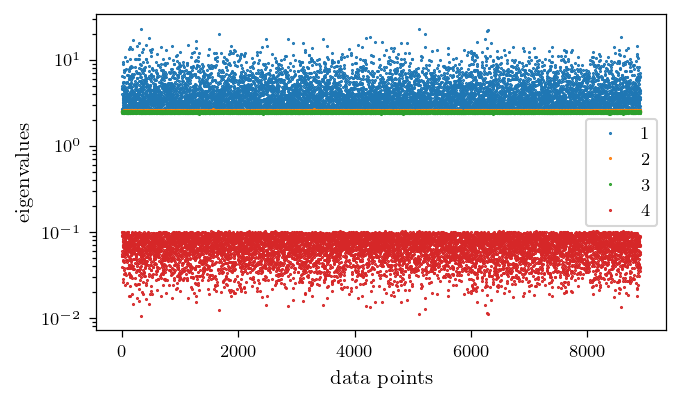

In [9]:
fig, ax = plt.subplots(figsize=set_figsize(textwidth_fraction=0.8, height_to_width_ratio=0.6))
for n, e_val in enumerate(data_evals.T):
    ax.plot(1/e_val, '.', label=f"{n+1}")
ax.legend()
ax.set_yscale('log')

ax.set_xlabel('data points')
ax.set_ylabel('eigenvalues')

fig.tight_layout()
plt.show(fig)
plt.close(fig)

## Trained models

In [10]:
model_type = 'all'
columns_dict = {
    'Epochs': 'max_epochs',
    'Features': 'features',
    'Sparsity': 'sparsity',
    'Loss': 'valid_loss'
}

In [20]:
path = root / 'results/models/rqp4/'
series_list = []
for file in os.listdir(path):
    fpath = Path(file)
    if fpath.suffix == '.pt':
        model_data = torch.load(path / fpath.name)
        par_dict = {
            key:val
            for key, val in model_data['info']['config'].items()
            if key in {'max_epochs', 'batch_size', 'burst_dt', 'burst_size'}
        }
#         par_dict['layers (i,l,[h])'] = model_data['state']['best_model_dict'].keys()
        par_dict['train_size'] = model_data['info']['config']['loader']['train_size']
        par_dict['valid_size'] = model_data['info']['config']['loader']['valid_size']
        par_dict['features'] = model_data['info'].get('features', [])
#         par_dict['sparsity'] = model_data['best'].get('sparsity', 0)
        pruning = model_data['info']['config'].get('pruning')
        if pruning:
            par_dict['sparsity'] = pruning['target_sparsity']
        else:
            par_dict['sparsity'] = 0.0
        par_dict['valid_loss'] = model_data['history']['valid_losses'][model_data['best']['epoch']-1]
        par_dict['model_id'] = fpath.stem
        series_list.append(par_dict)
models_df = pd.DataFrame(series_list)
# models_df.set_index('model_id').sort_values(by='model_id')
(
models_df.set_index('model_id')
         .sort_values(by='model_id')
         .style.format({
             'sparsity': '{0:.0%}',
             'valid_loss': '{:.2}',
             'features': lambda x: "{:}".format(list(x)),  # TODO: format with dashes
             'burst_dt': '{:.0e}',
             'burst_size': '{:.0e}'
         })
         .set_properties(**{'font-size': '12pt',})
)

,max_epochs,batch_size,burst_dt,burst_size,train_size,valid_size,features,sparsity,valid_loss
model_id,,,,,,,,,
meandrift_1,200,16,nan,nan,6238,2673,"[4, 16, 1, 16, 4]",0%,0.36
meandrift_2,200,16,nan,nan,6238,2673,"[4, 32, 1, 32, 4]",0%,0.38
meandrift_3,100,16,nan,nan,6238,2673,"[4, 16, 16, 1, 16, 16, 4]",0%,0.00044
pruned_0,35,16,4e-03,1e+04,6238,2673,"[4, 8, 4, 1, 4, 8, 4]",70%,0.95
pruned_1,350,16,4e-03,1e+04,6238,2673,"[4, 32, 16, 1, 16, 32, 4]",70%,0.82
pruned_2,350,16,4e-03,1e+04,6238,2673,"[4, 32, 32, 1, 32, 32, 4]",80%,0.82
pruned_3,350,16,4e-03,1e+04,6238,2673,"[4, 32, 32, 1, 32, 32, 4]",90%,0.74
simple_0,250,16,4e-03,1e+04,6238,2673,"[4, 8, 4, 1, 4, 8, 4]",0%,0.38
simple_1,200,16,4e-03,1e+04,6238,2673,"[4, 16, 1, 16, 4]",0%,0.81


## Plot loss for every epoch

In [21]:
model_id = 'meandrift_3'

In [22]:
model_data = torch.load(f'../results/models/RQP4/{model_id}.pt')
config = json.load(open(f'../configs/RQP4/{model_id}.json'))
print(f'{model_data.keys() = }')

model_data.keys() = dict_keys(['id', 'info', 'best', 'history'])


In [23]:
train_losses = model_data['history']['train_losses']
valid_losses = model_data['history']['valid_losses']
checkpoints = model_data['history']['checkpoints']
epochs = range(1, model_data['info']['config']['max_epochs']+1)
best_epoch = model_data['best']['epoch']

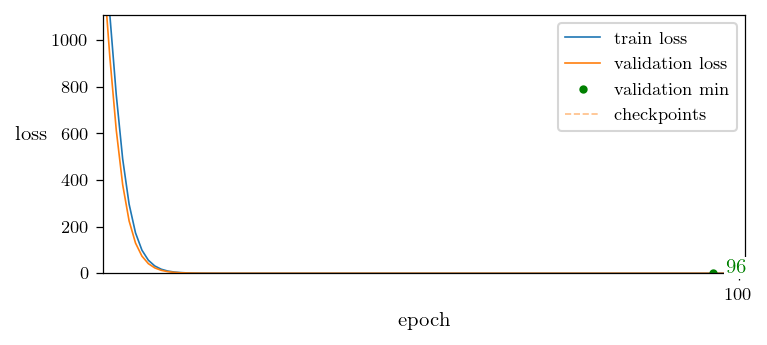

In [24]:
fig, ax = plt.subplots(figsize=set_figsize(textwidth_fraction=0.9, height_to_width_ratio=0.46))

ax.plot(epochs, train_losses, label="train loss")
loss_line, = ax.plot(epochs, valid_losses, label="validation loss")
loss_color = loss_line.get_color()

# regular checkpoints
check_ids = [check_id for check_id, check_type in checkpoints if check_type != 'best']
check_loss = [valid_losses[idx-1] for idx in check_ids]
plt.vlines(x=check_ids, ymin=0, ymax=check_loss, ls='--', color=loss_color, alpha=0.5, label='checkpoints')

# smallest validation loss / "best" model
smallest_loss = valid_losses[best_epoch-1]
plt.vlines(x=best_epoch, ymin=0, ymax=smallest_loss, color='g')
ax.plot(best_epoch, smallest_loss, 'o', color='g', label='validation min', markersize=3)

ax.text(best_epoch+2, .3*smallest_loss, f'{best_epoch}', rotation=0, color='g', bbox={'fc': 'w', 'ec':'None', 'boxstyle':'Square, pad=0.1'})

ax.set_xlim([epochs[0], epochs[-1]+1])
ax.set_ylim([0.0, train_losses[1]])
ax.set_xticks(check_ids[1::2])
ax.set_xlabel("epoch")
ax.set_ylabel("loss", rotation=0, labelpad=10)
ax.legend()

fig.tight_layout()
fig.savefig(root / f"results/figs/{model_id}_loss.pdf", dpi=300)
plt.show(fig)
plt.close(fig)

## Load Model

In [25]:
model = models.SimpleAutoencoder(**model_data['info']['arguments'])
model_dict = 'model_dict'

In [26]:
def remove_mask(model_dict):
    mask_state_dict = dict(filter(lambda elem: elem[0].endswith('_mask'), model_dict.items()))
    orig_state_dict = dict(filter(lambda elem: elem[0].endswith('_orig'), model_dict.items()))
    rest = dict(filter(lambda elem: elem[0].endswith(('weight', 'bias')), model_dict.items()))
    state_dict = {
        key.replace('_orig',''): val_orig * val_mask
        for (key, val_orig), val_mask in zip(orig_state_dict.items(), mask_state_dict.values())
    }
    return {**state_dict, **rest}

In [27]:
check_epoch = 'best'

In [28]:
if check_epoch == 'best':
    state_dict = remove_mask(model_data['best']['model_dict'])
    check_epoch = best_epoch
else:
    check_dict = torch.load(f'../results/models/RQP4/{model_id}/state_at_{check_epoch}.pt')
    state_dict = remove_mask(check_dict['model_dict'])
model.load_state_dict(state_dict)

<All keys matched successfully>

In [29]:
model.eval()

SimpleAutoencoder(
  (encoder): Sequential(
    (enc_lay0): Linear(in_features=4, out_features=16, bias=True)
    (enc_act0): Sigmoid()
    (enc_lay1): Linear(in_features=16, out_features=16, bias=True)
    (enc_act1): Sigmoid()
    (enc_lay2): Linear(in_features=16, out_features=1, bias=False)
  )
  (decoder): Sequential(
    (dec_lay2): Linear(in_features=1, out_features=16, bias=False)
    (dec_act1): Sigmoid()
    (dec_lay1): Linear(in_features=16, out_features=16, bias=True)
    (dec_act0): Sigmoid()
    (dec_lay0): Linear(in_features=16, out_features=4, bias=True)
  )
)

## Encoder accuracy

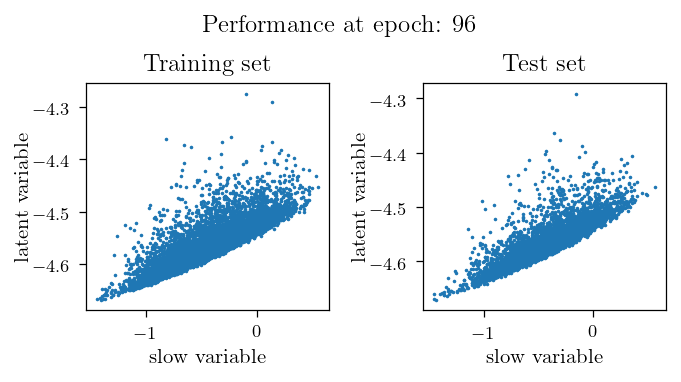

In [30]:
fig, axs = plt.subplots(ncols=2, figsize=set_figsize(textwidth_fraction=0.8, height_to_width_ratio=0.55))

train_test_data = [train_data, test_data]
for ax, data, title in zip(axs, train_test_data, ['Training set', 'Test set']):
    slow_var = datasets.RQP4.slow_map(data.T).detach().numpy()
    lat_var = model(data)[1].detach().numpy()
    try:
        ax.scatter(slow_var, lat_var.T, s=.5)
    except ValueError:
        print('Latent layer too large.')
        plt.close(fig)
    
    ax.set_title(f'{title}')
    ax.set_ylabel('latent variable', labelpad=0)
    ax.set_xlabel('slow variable')

fig.tight_layout()

fig.suptitle(f'Performance at epoch: {check_epoch}')
fig.subplots_adjust(top=0.8)
fig.savefig(root / f"results/figs/{model_id}_slowvar.pdf", dpi=300)
plt.show(fig)
plt.close(fig)

## Reconstruction visualization

In [31]:
rec_train_data = model(train_data)[0]
rec_train_data_np = rec_train_data.detach().numpy()

In [32]:
def coord_grid(fig, darray, var='x'):
    gs = GridSpec(3, 3, figure=fig, hspace=0.05, wspace=0.05)

    for n, coord in enumerate(darray.T[:-1]):
        for m in range(n+1):
            ax = fig.add_subplot(gs[n, m])
    #         ax.set_title(f"{n}, {m-1}")
            ax.scatter(darray[:,m-1], coord, s=0.5)
            ax.set_xlim([-1.5, 1.5])
            ax.set_ylim([-1.5, 1.5])
            ax.set_aspect('equal')
            if n == 2:
                ax.set_xlabel(f'${var}_{(m-1) % 4}$')
    #             ax.set_xticks([-.25, 0.0, +.25])
            else:
                ax.set_xticklabels([])
            if m == 0:
                ax.set_ylabel(f'${var}_{n}$', rotation=0)
    #             ax.set_yticks([-.25, 0.0, +.25])
            else:
                ax.set_yticklabels([])
    return gs

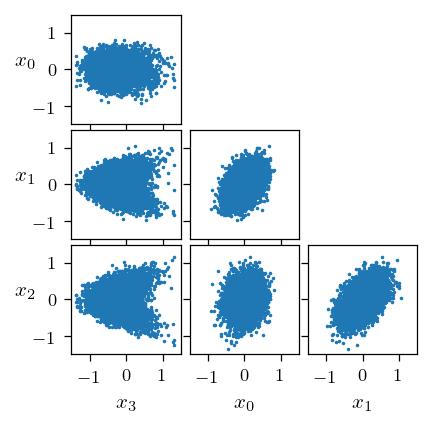

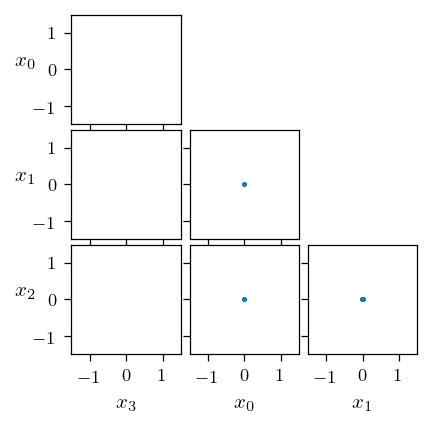

In [33]:
fig = plt.figure(figsize=(3,3))
gs = coord_grid(fig, train_data_np)

plt.show(fig)
plt.close(fig)

fig = plt.figure(figsize=(3,3))
gs = coord_grid(fig, rec_train_data_np)

plt.show(fig)
plt.close(fig)

In [34]:
rec_train_data_np

array([[-2.0518899e-05,  3.4362078e-05,  1.1101365e-06,  5.0003767e+00],
       [ 2.0429492e-05, -3.4540892e-05, -7.2345138e-06,  4.9995861e+00],
       [ 1.3113022e-05, -2.2083521e-05, -5.8338046e-06,  4.9997282e+00],
       ...,
       [ 3.9175153e-05, -6.6190958e-05, -1.0870397e-05,  4.9992218e+00],
       [-3.6954880e-06,  6.1094761e-06, -2.4363399e-06,  5.0000525e+00],
       [ 2.7269125e-06, -4.7087669e-06, -3.7476420e-06,  4.9999294e+00]],
      dtype=float32)

In [308]:
hid_rec_data = np.stack([datasets.RQP4.slow_map(rec_train_data_np.T), rec_train_data_np.T[2], rec_train_data_np.T[1], rec_train_data_np.T[0]]).T
hid_rec_data.shape

(8911, 4)

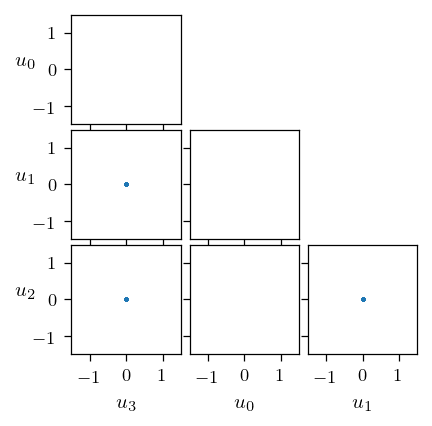

In [309]:
fig = plt.figure(figsize=(3,3))
gs = coord_grid(fig, hid_rec_data, var='u')

plt.show(fig)
plt.close(fig)

In [310]:
strange_data = train_data_np[(hid_rec_data.T[1:3]<-0.2).all(0)]

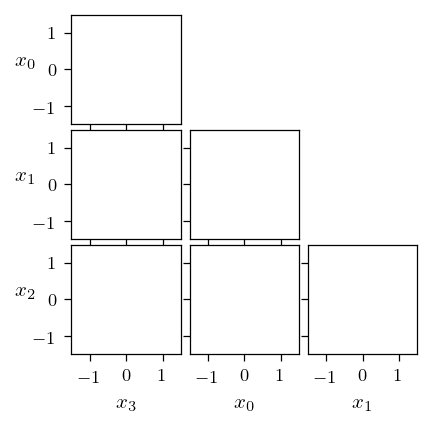

In [311]:
fig = plt.figure(figsize=(3,3))
gs = coord_grid(fig, strange_data)

plt.show(fig)
plt.close(fig)

NameError: name 'rqp4_dat' is not defined

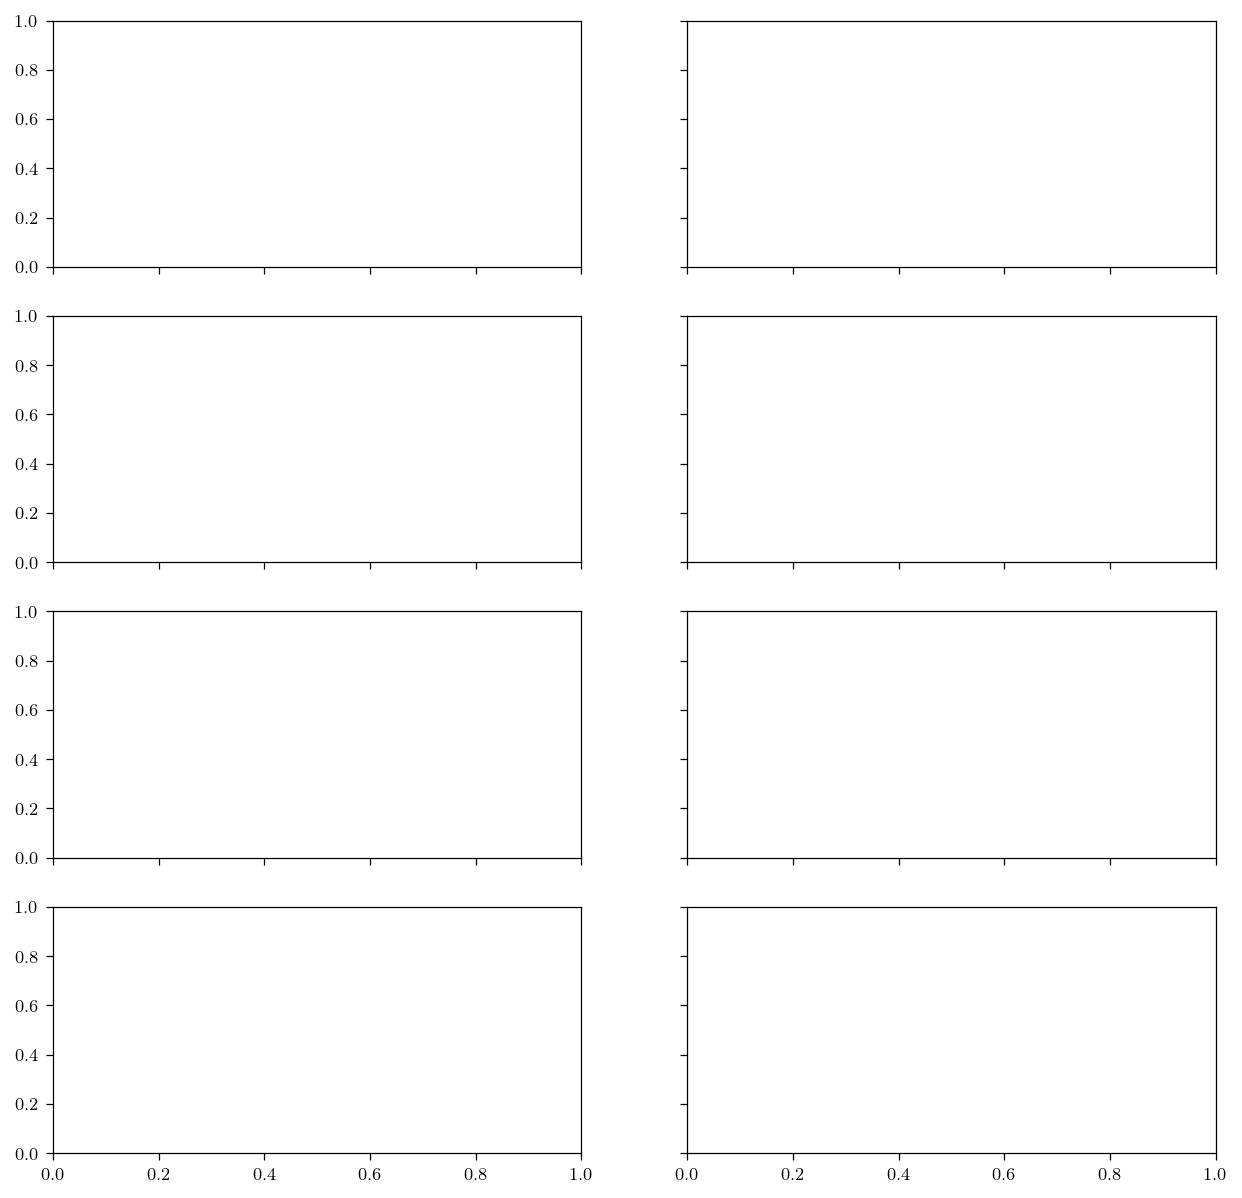

In [74]:
fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(10,10), sharey=True, sharex='col')

coords = np.array([point.numpy() for point, _ in train_dataset]).T
slow_var, lat_var = np.array([(rqp4_dat['smap'](point), model(point)[1].item()) for point, covi in train_dataset]).T

for n, ax_row in enumerate(axs):
    ax_row[0].scatter(lat_var, coords[n], s=2)
    ax_row[1].scatter(slow_var, coords[n], s=2)
    ax_row[0].set_ylabel(f'$x_{n+1}$', rotation=0)

ax_row[0].set_xlabel('latent variable')
ax_row[1].set_xlabel('slow variable')

fig.tight_layout()
plt.show()
plt.close(fig)

## Sparsity patterns

In [65]:
mpl.rcParams['text.usetex'] = False
if 'pruned' in model_id:
    par_dict = {}
    for coder_name, coder in model.named_children():
        for name, par in coder.named_parameters():
            mat = par.detach().numpy()
            if mat.ndim == 1:
                mat = mat[:, np.newaxis]
            layer_name, par_name = name.split('.')
            value = par_dict.setdefault(layer_name, [])

            value.append((name, mat.T))

    ncols = len(par_dict)
    import matplotlib.gridspec as gridspec
    fig = plt.figure(constrained_layout=True, figsize=(9, 2.5))

    gs = fig.add_gridspec(2, ncols)
    clim = (0, 1)
    # plt.setp(axs, xticks=[], yticks=[])
    for n, (layer_name, par_list) in enumerate(par_dict.items()):
        if len(par_list) == 1:
            ax = fig.add_subplot(gs[0,n])
            ax.imshow(np.absolute(par_list[0][1])>0, clim=clim)
            ax.set_title(par_list[0][0])
        else:
    #         gap = -np.ones((2, par_list[0][1].shape[1]))
    #         mat = np.vstack((par_list[0][1], gap, par_list[1][1]))
            ax_w = fig.add_subplot(gs[0,n])
            ax_w.imshow(np.absolute(par_list[0][1])>0)
            ax_w.set_title(par_list[0][0])
            ax_b = fig.add_subplot(gs[1,n], sharex=ax_w)
            ax_b.imshow(np.absolute(par_list[1][1])>0)
            ax_b.set_title(par_list[1][0])

    all_axes = fig.get_axes()
    plt.setp(all_axes, xticks=[], yticks=[])
    
    fig.savefig(root / f"results/figs/{model_id}_wmats.pdf", dpi=300)
    plt.show(fig)
    plt.close(fig)
mpl.rcParams['text.usetex'] = True